## Install environment
pip install opencv-python, tifffile
pip install numpy, matplotlib

In [17]:
import cv2
import numpy as np
import os
import tifffile as tiff
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import math

In [ ]:
# Load two TIFF images
def load_images(image1_path, image2_path):
    img1 = tiff.imread(image1_path)
    img2 = tiff.TiffFile(image2_path)
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2_gray = img2.pages[0].asarray().squeeze()
    # Invert image, very important step, as MxIF is dark field image, while H&E is bright field image
    # Alignment will fail if there is no inversion
    img2_gray = cv2.bitwise_not(img2_gray) 
    return img1_gray, img2_gray

# Apply SIFT feature detection and alignment
def sift_alignment(img1, img2):
    sift = cv2.SIFT_create()
    keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img2, None)
    
    # Use FLANN-based matcher
    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)
    
    # Apply ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)
    
    # Extract matched keypoints
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    
    # Compute homography matrix
    matrix, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    
    # Warp image
    aligned_img = cv2.warpPerspective(img1, matrix, (img2.shape[1], img2.shape[0]))
    return aligned_img, good_matches, keypoints1, keypoints2, matrix

def draw_points(source_points, target_points, title):
    plt.figure(1)
    plt.scatter(source_points[:, 1], source_points[:, 0], c='r', s=10)
    plt.scatter(target_points[:, 1], target_points[:, 0], c='b', s=10)
    plt.legend(["HE", "MxIF"])
    plt.title(title)
    plt.axis('equal')
    plt.show()
# 

In [ ]:



def get_rotation_translation(matrix):
    # Calculate rotation angle in degrees
    rotation_angle = math.degrees(math.atan2(matrix[1, 0], matrix[0, 0]))
    # Calculate translation distance
    translation_distance = math.sqrt(matrix[0, 2]**2 + matrix[1, 2]**2)

    return rotation_angle, translation_distance


(0.15367310937112738, 144.9718052252821)

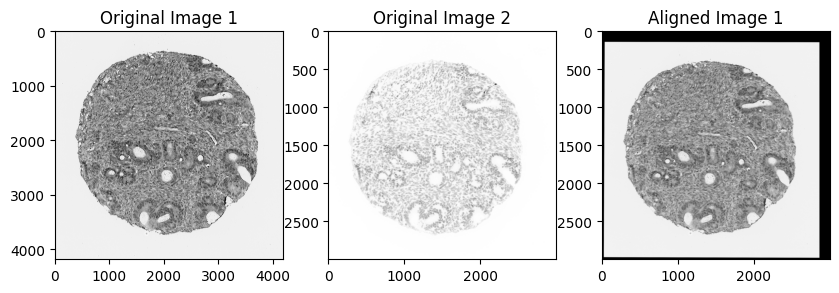

In [ ]:
def visualize_image_alignment(img1, img2, aligned_img):
    # Plot results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.title("Original Image 1")
    plt.imshow(img1, cmap='gray')
# plt.plot([keypoint.pt[0] for keypoint in keypoints1], [keypoint.pt[1] for keypoint in keypoints1], 'ro')
    plt.subplot(1, 3, 2)
    plt.title("Original Image 2")
    plt.imshow(img2, cmap='gray')
# plt.plot([keypoint.pt[0] for keypoint in keypoints2], [keypoint.pt[1] for keypoint in keypoints2], 'bo')
    plt.subplot(1, 3, 3)
    plt.title("Aligned Image 1")
    plt.imshow(aligned_img, cmap='gray')
# plt.axis('off')
    plt.show()

visualize_image_alignment()

In [ ]:
# TODO: quantitatively evaluate the alignment results
# 1. calculate delta theta and delta translation based on the homography matrix.
# 2. Apply the homography matrix to the manually labeled landmarks of image 1, and compare with the landmarks of image 2, calculate delta distance.


# add setting.json to the .vscode folder
# '''
# {
#     "python.analysis.extraPaths": [
#         "./MultimodalityHistoComb/release/eval"
#     ]
# }
# '''


from eval_utils import *

DEBUG = False

Sec = 2

HE_pixel_size = 0.2201  # unit micron
MxIF_pixel_size = 0.325

core_list_fn = "MultimodalityHistoComb/release/core_list.txt"
core_list = open(core_list_fn, 'r').readlines()
roi_id_list = []
for core in core_list:
    roi_id = core.split(".")[0]
    roi_id_list.append(roi_id)


img_data_dir = "/Users/jjiang10/Data/OV_TMA"  #TODO: change to your own data path
output_dir = "/Users/jjiang10/Data/OV_TMA/align_eval"  #TODO: change to your own data path

data_root_dir = "/temp/Ovarian_TMA"  #TODO: change to your own data path
eval_data_root = os.path.join(data_root_dir, "AlignmentEval", "GroundTruthEvaluation")
anno_data_root = os.path.join(data_root_dir, "AlignmentEval", "GroundTruthAnnotation")
if Sec == 1:
    # Sec1
    ground_truth_output_dir = os.path.join(eval_data_root, "GT_HE_Sec1_MxIF")
    HE_export_dir = os.path.join(anno_data_root, "HE_Sec1")
elif Sec == 2:
    # Sec2
    ground_truth_output_dir = os.path.join(eval_data_root, "GT_HE_Sec2_MxIF")
    HE_export_dir = os.path.join(anno_data_root, "HE_Sec2")
else:
    raise Exception("Undefined Section")

MxIF_export_dir = os.path.join(anno_data_root, "MxIF_Sec1")


if not os.path.exists(output_dir):
    os.makedirs(output_dir)
output_csv_fn = os.path.join(output_dir, "alignment_eval_Sec%d.csv" % Sec)
df = pd.DataFrame(columns=["ROI", "GT_dist", "Test_dist", "GT_angle", "Test_angle", "GT_landmark", "Test_landmark"])

for roi in roi_id_list:
    print("Processing %s" % roi)
    HE_landmarks_fn = os.path.join(HE_export_dir, roi+"_align_anno_8.csv")
    MxIF_landmarks_fn = os.path.join(MxIF_export_dir, roi+"_align_anno_8.csv")
    point_sort_fn = os.path.join(data_root_dir, "GroundTruthAnnotation", "Landmark_correspondence", "Sec%d" %Sec, roi+".csv")

    gt_trans_fn = os.path.join(eval_data_root, "GT_HE_Sec%d_MxIF" % Sec, roi+"_gt_trans.npy")

    HE_img_path = os.path.join(img_data_dir, f'HE_{roi}.tif')
    MxIF_img_path = os.path.join(img_data_dir, f'MxIF_{roi}.ome.tif')
    HE_img, MxIF_img = load_images(HE_img_path, MxIF_img_path)
    aligned_img, good_matches, keypoints1, keypoints2, aff_matrix = sift_alignment(HE_img, MxIF_img)

    sorted_HE_landmarks, sorted_MxIF_landmarks = get_sorted_annotation_landmark_pairs(HE_landmarks_fn, MxIF_landmarks_fn, point_sort_fn)
    sorted_HE_landmarks_um = sorted_HE_landmarks * HE_pixel_size
    sorted_MxIF_landmarks_um = sorted_MxIF_landmarks * MxIF_pixel_size

    gt_M = np.load(gt_trans_fn)

    # check distance between transformed source landmark points and target landmark points
    gt_trans_HE_landmarks_um = apply_aff_trans2points(sorted_HE_landmarks_um, gt_M)
    gt_landmark_dist = calculate_transformed_landmark_dist(gt_trans_HE_landmarks_um, sorted_MxIF_landmarks_um)

    trans_HE_landmarks_um = apply_aff_trans2points(sorted_HE_landmarks, aff_matrix)*MxIF_pixel_size
    test_landmark_dist = calculate_transformed_landmark_dist(trans_HE_landmarks_um, sorted_MxIF_landmarks_um)

    gt_rotation_angle, gt_translation_distance = get_rotation_translation(gt_M)
    test_rotation_angle, test_translation_distance = get_rotation_translation(aff_matrix)
    if DEBUG:
        draw_points(gt_trans_HE_landmarks_um, sorted_MxIF_landmarks_um, "Landmarks with ground truth transformation")
        draw_points(trans_HE_landmarks_um, sorted_MxIF_landmarks_um, "Landmarks with test transformation")

        print("\t Distance differences: %f\t %f" % (gt_landmark_dist, test_landmark_dist))
    data_list = [roi, gt_translation_distance, test_translation_distance, gt_rotation_angle, test_rotation_angle, gt_landmark_dist, test_landmark_dist] 

    df = pd.concat([pd.DataFrame([data_list], columns=df.columns), df], ignore_index=True)

df.to_csv(output_csv_fn)

# draw plots
vals = list(abs(df['cpd_dist']-df['gt_dist']))
avg = sum(vals)/len(vals)
plt.figure(figsize=(4,3), dpi=300)
plt.xlabel(r'$\mu$' + "m")
plt.ylabel("percentage")
sns.histplot(vals, stat='percent', bins=5, shrink=0.5, color='red', edgecolor="black")
plt.axvline(avg, 0, 0.8, color='brown', linestyle='--')
plt.title(r'$\Delta$' +" Distance")
plt.tight_layout()
plt.show()


vals = list(abs(df['cpd_degrees']-df['gt_degrees']))
avg = sum(vals)/len(vals)
plt.figure(figsize=(4,3), dpi=300)
plt.xlabel("Degree" + '$^\circ$')
plt.ylabel("percentage")
sns.histplot(vals, stat='percent', bins=5, shrink=0.5, color='green', edgecolor="black")
plt.axvline(avg, 0, 0.8, color='brown', linestyle='--')
plt.title(r'$\Delta$' + " Rotation")
plt.tight_layout()
plt.show()

vals = list(abs(df['cpd_delta']-df['gt_delta']))
avg = sum(vals)/len(vals)
plt.figure(figsize=(4,3), dpi=300)
plt.xlabel(r'$\mu$' + "m")
plt.ylabel("percentage")
sns.histplot(vals, stat='percent', bins=5, shrink=0.5, color='blue', edgecolor="black")
plt.axvline(avg, 0, 0.8, color='brown', linestyle='--')
plt.title(r'$\Delta$' + " Translation")
plt.tight_layout()
plt.show()

print("Done")